# Putting it all together

This notebook shows an example of how to convert data from the saved datasets, plus models trained earlier, into the output show below in columns D-G. 
[WORK IN PROGRESS] 

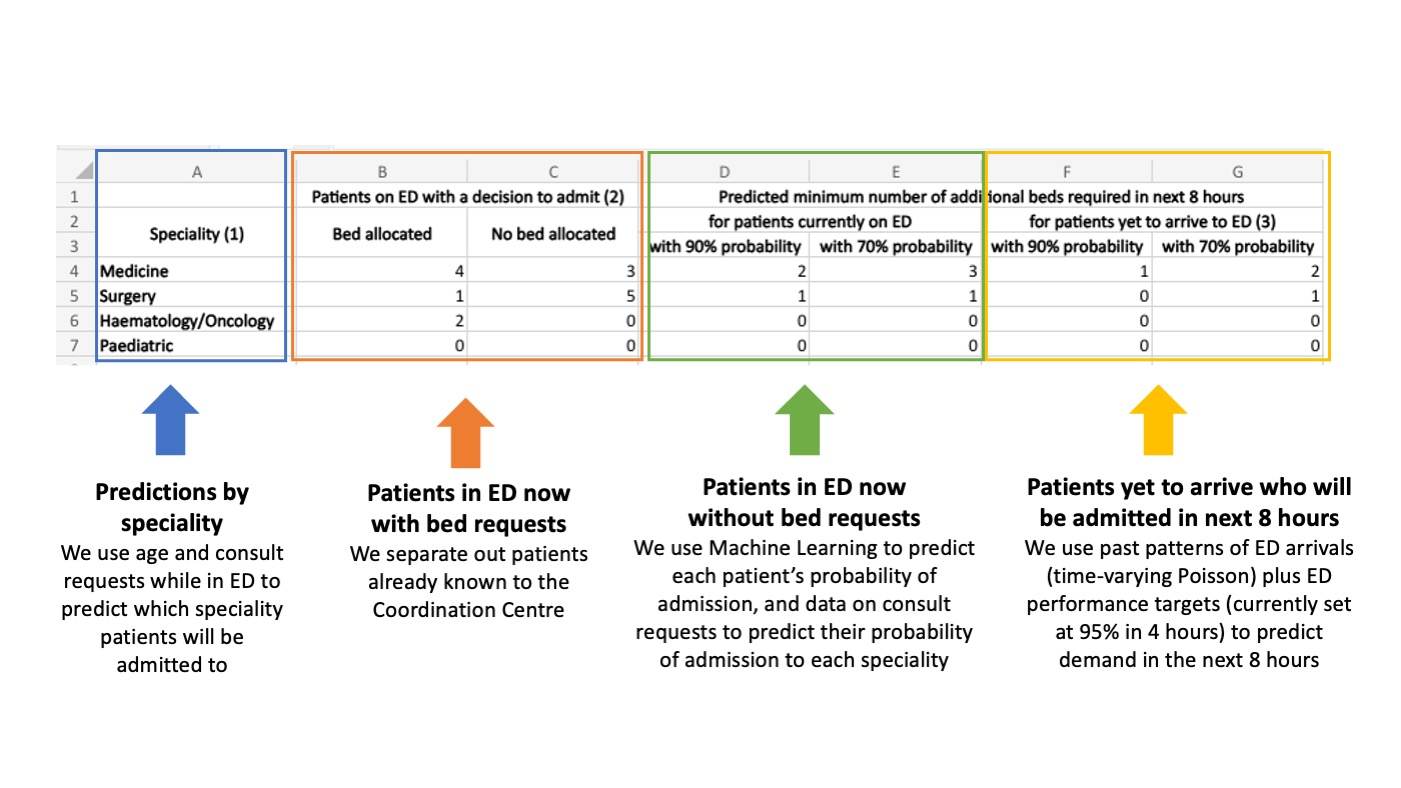

In [1]:
from IPython.display import Image
Image(filename='img/UCLH application with annotation.jpg')

In order to recreate the output this notebook, prior steps are

* train a model predicting admission to ED (this is done in notebook [4a_Predict_Probability_of_admission_from_ED.ipynb](4a_Predict_Probability_of_admission_from_ED.ipynb))
* train a model predicting admisson to each specialty if admitted (this is done in notebook [4c_Predict_Probability_of_admission_to_specialty.ipynb](4c_Predict_Probability_of_admission_to_specialty.ipynb))
* train a model predicting demand from patients yet-to-arrive (this is done in notebook [4d_Predict_demand_from_patients_yet_to_arrive.ipynb](4d_Predict_demand_from_patients_yet_to_arrive.ipynb))
* save all three models in the [trained-models folder](../trained-models/)


## Set up notebook environment

In [4]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [5]:
from patientflow.load import set_project_root
project_root = set_project_root()


Inferred project root: /Users/zellaking/Repos/patientflow


## Load parameters and set file paths

In [6]:
import pandas as pd
from patientflow.load import load_data
from patientflow.load import set_file_paths

# set file paths
data_folder_name = 'data-public'
data_file_path = project_root / data_folder_name

data_file_path, media_file_path, model_file_path, config_path = set_file_paths(project_root, 
               data_folder_name=data_folder_name)


# load data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

# load params
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]
prediction_times = params["prediction_times"]

x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
prediction_window = params["prediction_window"]
epsilon = float(params["epsilon"])
yta_time_interval = params["yta_time_interval"]

print(f'\nTraining set starts {start_training_set} and ends on {start_validation_set - pd.Timedelta(days=1)} inclusive')
print(f'Validation set starts on {start_validation_set} and ends on {start_test_set - pd.Timedelta(days=1)} inclusive' )
print(f'Test set starts on {start_test_set} and ends on {end_test_set- pd.Timedelta(days=1)} inclusive' )

print(f'\nThe coordinates used to derive the aspirational curve are ({int(x1)},{y1}) and ({int(x2)},{y2})')
print(f'The prediction window over which prediction will be made is {prediction_window/60} hours')
print(f'In order to calculate yet-to-arrive rates of arrival, the prediction window will be divied into intervals of {yta_time_interval} minutes')

Configuration will be loaded from: /Users/zellaking/Repos/patientflow/config.yaml
Data files will be loaded from: /Users/zellaking/Repos/patientflow/data-public
Trained models will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public
Images will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public/media

Training set starts 2031-03-01 and ends on 2031-08-31 inclusive
Validation set starts on 2031-09-01 and ends on 2031-09-30 inclusive
Test set starts on 2031-10-01 and ends on 2031-12-31 inclusive

The coordinates used to derive the aspirational curve are (4,0.76) and (12,0.99)
The prediction window over which prediction will be made is 8.0 hours
In order to calculate yet-to-arrive rates of arrival, the prediction window will be divied into intervals of 15 minutes


## Pick a random row to simulate the real-time environment

In [7]:
from datetime import datetime, time

# Set seed
import numpy as np
np.random.seed(2404)

# Randomly pick a prediction moment to do inference on
random_row = ed_visits[ed_visits.training_validation_test == 'test'].sample(n=1)
prediction_time = random_row.prediction_time.values[0]
prediction_date = random_row.snapshot_date.values[0]
prediction_moment = datetime.combine(pd.to_datetime(prediction_date).date(), datetime.min.time()).replace(hour=prediction_time[0], minute=prediction_time[1])

prediction_snapshots = ed_visits[(ed_visits.prediction_time == prediction_time) & \
            (ed_visits.snapshot_date == prediction_date)]
prediction_snapshots

snapshot_date prediction_time  visit_number  elapsed_los sex  \
snapshot_id                                                                
77829          12/23/2031        (15, 30)        153328        80793   M   
77935          12/23/2031        (15, 30)        153425        33893   F   
77947          12/23/2031        (15, 30)        153435         9900   F   
77951          12/23/2031        (15, 30)        153437        28398   F   
77960          12/23/2031        (15, 30)        153445        26421   F   
...                   ...             ...           ...          ...  ..   
78129          12/23/2031        (15, 30)        153611         3973   M   
78130          12/23/2031        (15, 30)        153612         3839   F   
78131          12/23/2031        (15, 30)        153613         3733   M   
78132          12/23/2031        (15, 30)        153614         3644   F   
78133          12/23/2031        (15, 30)        153615         3629   F   

            age_group arrival_method current_location_type  \
snapshot_id                                                  
77829          75-102      Ambulance                  sdec   
77935           25-34   Public Trans                  sdec   
77947           35-44            NaN                  sdec   
77951           25-34        Walk-in                majors   
77960          75-102      Ambulance                majors   
...               ...            ...                   ...   
78129           35-44        Walk-in               waiting   
78130           25-34        Walk-in               waiting   
78131           35-44        Walk-in               waiting   
78132           55-64        Walk-in               waiting   
78133            0-17        Walk-in               waiting   

             total_locations_visited  num_obs  ...  latest_lab_results_pco2  \
snapshot_id                                    ...                            
77829                              7      112  ...                     5.78   
77935                              5       34  ...                     4.84   
77947                              4       16  ...                     6.34   
77951                              4       79  ...                     5.39   
77960                              4       56  ...                     5.31   
...                              ...      ...  ...                      ...   
78129                              2        7  ...                      NaN   
78130                              2       16  ...                      NaN   
78131                              2        5  ...                      NaN   
78132                              1       16  ...                      NaN   
78133                              1        0  ...                      NaN   

             latest_lab_results_ph  latest_lab_results_wcc  \
snapshot_id                                                  
77829                        7.392                   10.31   
77935                        7.394                    9.71   
77947                        7.353                    9.25   
77951                        7.402                   15.27   
77960                        7.410                    3.96   
...                            ...                     ...   
78129                          NaN                     NaN   
78130                          NaN                     NaN   
78131                          NaN                     NaN   
78132                          NaN                     NaN   
78133                          NaN                     NaN   

             latest_lab_results_alb latest_lab_results_htrt  \
snapshot_id                                                   
77829                          46.0                     NaN   
77935                          49.0                     NaN   
77947                           NaN                     NaN   
77951                          46.0                     NaN   
779

## Generate predictions

The predictions for input into the spreadsheet output are generated by the create_predictions() function

In [8]:
from patientflow.predict.emergency_demand import create_predictions


We will load previously created models from disk and save to a dictionary of models

In [10]:
yta_model_name = f"ed_yet_to_arrive_by_spec_{int(prediction_window/60)}_hours"

special_category_dict = {
    'medical': 0.0,
    'surgical': 0.0,
    'haem/onc': 0.0,
    'paediatric': 1.0
}


model_names = {
    "admissions": "admissions",
    "specialty": "ed_specialty",
    "yet_to_arrive": yta_model_name
}

models = dict.fromkeys(model_names)




In [21]:
model_file_path

PosixPath('/Users/zellaking/Repos/patientflow/trained-models/public')

In [42]:
from patientflow.load import load_saved_model, get_model_key

# as the admissions models are a dictionary of models, we need to load each one
models["admissions"] = {}
for prediction_time in ed_visits.prediction_time.unique():

    model_name_for_prediction_time = get_model_key("admissions", prediction_time)
    models["admissions"][model_name_for_prediction_time]  = load_saved_model(model_file_path, "admissions", prediction_time)

models["ed_specialty"] = load_saved_model(model_file_path, "specialty")
models[model_names["yet_to_arrive"]] = load_saved_model(model_file_path, yta_model_name)


In [43]:
models["ed_specialty"]

SequencePredictor(
    input_var='consultation_sequence',
    grouping_var='final_sequence',
    outcome_var='specialty',
    apply_special_category_filtering=False,
    admit_col='is_admitted'
)

In the cell below we create the predictions for this randomly chosen moment in time: 

In [44]:
from patientflow.predict.emergency_demand import create_predictions


create_predictions(
    models = models,
    model_names=model_names,
    prediction_time = prediction_time,
    prediction_snapshots = prediction_snapshots,
    specialties = ['surgical', 'haem/onc', 'medical', 'paediatric'],
    prediction_window_hrs = prediction_window/60,
    cdf_cut_points =  [0.9, 0.7], 
    x1 = x1,
    y1 = y1,
    x2 = x2, 
    y2 = y2)

{'surgical': {'in_ed': [2, 3], 'yet_to_arrive': [0, 0]},
 'haem/onc': {'in_ed': [0, 1], 'yet_to_arrive': [0, 0]},
 'medical': {'in_ed': [6, 7], 'yet_to_arrive': [0, 1]},
 'paediatric': {'in_ed': [0, 1], 'yet_to_arrive': [0, 0]}}